### Make sure desired packages are installed with pip

In [8]:
!pip install metpy
!pip install netCDF4
!pip install siphon

from datetime import datetime, timedelta
from netCDF4 import Dataset, num2date
from calendar import monthrange
from datetime import datetime
import itertools

from netCDF4 import date2num, num2date
import numpy as np
from pyproj import Proj
from siphon.catalog import TDSCatalog
import xarray as xr

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import folium
import os

In [84]:

# Spatial location to find stuff
lats = np.linspace(68.5,70,5)
lons = np.linspace(-135.5,-134,5)

print(lats, lons)

years = np.arange(2000,2020)
months = np.arange(6,10)
Subsurface_fields = ['tsoil','soill','soilw']
Surface_fields = ['air.2m','uwnd.10m','vwnd.10m','pres.sfc','dswrf','dlwrf','uswrf.ntat','ulwrf.ntat']

clear = False


Dir = 'Data/Subsurface/'
if clear == True:
    for i,dsname in enumerate(os.listdir(Dir)):
        os.remove(Dir+dsname)
        
base_catalog = 'http://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/subsurface/catalog.xml'
main_cat = TDSCatalog(base_catalog)

for year, month, varname in itertools.product(years, months,Subsurface_fields):
    
    dsname = '{}.{:4d}{:02d}.nc'.format(varname, year, month)
    if os.path.isfile(Dir+dsname)==False: 
    
        print('{}: downloading...'.format(dsname), end='')

        # Grab it using opendap--manually convert to CF to work around the
        # fact that missing_value and _FillValue differ
        ds = xr.open_dataset(main_cat.datasets[dsname].access_urls['OPENDAP'],
                             decode_cf=False)
        ds = xr.conventions.decode_cf(ds, mask_and_scale=False)

        # Grab the projection variable and convert our points to that
        # Probably not strictly necessary
        var = varname.split('.')[0]
        proj_var = ds[ds[var].grid_mapping]
        proj = Proj(proj='lcc', lat_0=proj_var.latitude_of_projection_origin,
                lon_0=proj_var.longitude_of_central_meridian,
                lat_1=proj_var.standard_parallel[0],
                lat_2=proj_var.standard_parallel[1],
                x_0=proj_var.false_easting, y_0=proj_var.false_northing,
                ellps='sphere')
        x, y = proj(lons, lats)
        # Subset the data
        print('subsetting...', end='')
    #     ds.
        pt_ds = ds.sel(x=x, y=y, method='nearest')
        print('saving...', end='')

        # Save to disk
        pt_ds.to_netcdf(Dir+dsname)
        print('done.')

Dir = 'Data/Surface/'
if clear == True:
    for i,dsname in enumerate(os.listdir(Dir)):
        os.remove(Dir+dsname)
    
base_catalog = 'http://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/monolevel/catalog.xml'
main_cat = TDSCatalog(base_catalog)

for year, varname in itertools.product(years,Surface_fields):
#     # Figure out what to grab
    dsname = '{}.{:4d}.nc'.format(varname, year)
    
    if os.path.isfile(Dir+dsname)==False: 


        print('{}: downloading...'.format(dsname), end='')

        # Grab it using opendap--manually convert to CF to work around the
        # fact that missing_value and _FillValue differ
        ds = xr.open_dataset(main_cat.datasets[dsname].access_urls['OPENDAP'],
                             decode_cf=False)
        ds = xr.conventions.decode_cf(ds, mask_and_scale=False)

        # Grab the projection variable and convert our points to that
        # Probably not strictly necessary
        var = varname.split('.')[0]
        proj_var = ds[ds[var].grid_mapping]
        proj = Proj(proj='lcc', lat_0=proj_var.latitude_of_projection_origin,
                lon_0=proj_var.longitude_of_central_meridian,
                lat_1=proj_var.standard_parallel[0],
                lat_2=proj_var.standard_parallel[1],
                x_0=proj_var.false_easting, y_0=proj_var.false_northing,
                ellps='sphere')
        x, y = proj(lons, lats)
        # Subset the data
        print('subsetting...', end='')
    #     ds.
        pt_ds = ds.sel(x=x, y=y, method='nearest')
        print('saving...', end='')

        # Save to disk
        pt_ds.to_netcdf(Dir+dsname)
        print('done.')

[68.5   68.875 69.25  69.625 70.   ] [-135.5   -135.125 -134.75  -134.375 -134.   ]
pres.sfc.2000.nc: downloading...subsetting...saving...done.
dswrf.2000.nc: downloading...subsetting...saving...done.
dlwrf.2000.nc: downloading...subsetting...saving...done.
uswrf.ntat.2000.nc: downloading...subsetting...saving...done.
ulwrf.ntat.2000.nc: downloading...subsetting...saving...done.
air.2m.2001.nc: downloading...subsetting...saving...done.
uwnd.10m.2001.nc: downloading...subsetting...saving...done.
vwnd.10m.2001.nc: downloading...subsetting...saving...done.
pres.sfc.2001.nc: downloading...subsetting...saving...done.
dswrf.2001.nc: downloading...subsetting...saving...done.
dlwrf.2001.nc: downloading...subsetting...saving...done.
uswrf.ntat.2001.nc: downloading...subsetting...saving...done.
ulwrf.ntat.2001.nc: downloading...subsetting...saving...done.
air.2m.2002.nc: downloading...subsetting...saving...done.
uwnd.10m.2002.nc: downloading...subsetting...saving...done.
vwnd.10m.2002.nc: downlo

pres.sfc.2017.nc: downloading...subsetting...saving...done.
dswrf.2017.nc: downloading...subsetting...saving...done.
dlwrf.2017.nc: downloading...subsetting...saving...done.
uswrf.ntat.2017.nc: downloading...subsetting...saving...done.
ulwrf.ntat.2017.nc: downloading...subsetting...saving...done.
air.2m.2018.nc: downloading...subsetting...saving...done.
uwnd.10m.2018.nc: downloading...subsetting...saving...done.
vwnd.10m.2018.nc: downloading...subsetting...saving...done.
pres.sfc.2018.nc: downloading...subsetting...saving...done.
dswrf.2018.nc: downloading...subsetting...saving...done.
dlwrf.2018.nc: downloading...subsetting...saving...done.
uswrf.ntat.2018.nc: downloading...subsetting...saving...done.
ulwrf.ntat.2018.nc: downloading...subsetting...saving...done.
air.2m.2019.nc: downloading...subsetting...saving...done.
uwnd.10m.2019.nc: downloading...subsetting...saving...done.
vwnd.10m.2019.nc: downloading...subsetting...saving...done.
pres.sfc.2019.nc: downloading...subsetting...sav

277.7926145273737


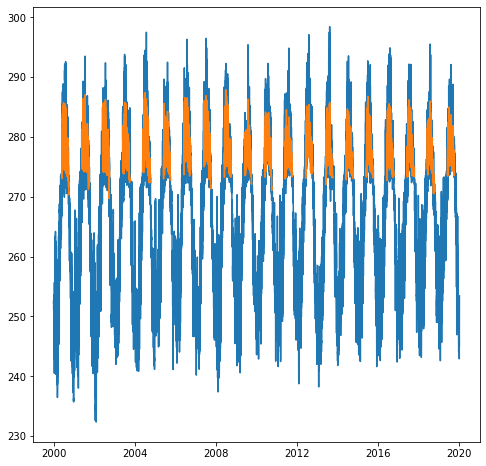

In [164]:
def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)
    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

Dir='Data/Subsurface/'
y = [-134.857734]
x = [69.386080]
Depth = [0,10]
for d,depth in enumerate(Depth):
    for i,dsname in enumerate(os.listdir(Dir)):
        fh = Dataset(Dir+dsname, mode='r')
        time=fh.variables['time'][:]
        lons = fh.variables['lon'][:]
        lats = fh.variables['lat'][:]
        var = dsname.split('.')[0]
        query = fh.variables[var][:]
        fh.close()
        idw = np.array([
            simple_idw(
                lons.flatten(),
                lats.flatten(),
                Q.flatten(),
                np.array(y),
                np.array(x)) for Q in query[:,d,:,:]]).flatten()
#         print(idw.shape)
        if i+d == 0:
            Data = pd.DataFrame(data={var+'_'+str(depth):idw},
                            index=datetime(1800,1,1)+timedelta(hours=1)*time)
        else:
            Data = Data.append(pd.DataFrame(data={var+'_'+str(depth):idw},
                            index=datetime(1800,1,1)+timedelta(hours=1)*time))
        
# print(query.shape)
            
Dir='Data/Surface/'
for i,dsname in enumerate(os.listdir(Dir)):
    fh = Dataset(Dir+dsname, mode='r')
    time=fh.variables['time'][:]
    lons = fh.variables['lon'][:]
    lats = fh.variables['lat'][:]
    var = dsname.split('.')[0]
    query = fh.variables[var][:]
    fh.close()
    idw = np.array([
        simple_idw(
            lons.flatten(),
            lats.flatten(),
            Q.flatten(),
            np.array(y),
            np.array(x)) for Q in query]).flatten()
    if i == -1:
        Data = pd.DataFrame(data={var:idw},
                        index=datetime(1800,1,1)+timedelta(hours=1)*time)
    else:
        Data = Data.append(pd.DataFrame(data={var:idw},
                        index=datetime(1800,1,1)+timedelta(hours=1)*time))
# print(Data)
Data.to_csv('CompiledData.csv')
Data=Data.groupby(Data.index).mean()
# Data['soill'].plot()
plt.figure(figsize=(8,8))
plt.plot(Data.index,Data['air'])
plt.plot(Data.index,Data['tsoil_0'])
# Data['soill']
print(Data['tsoil_0'].mean())
Data.to_csv('NARRData.csv')

In [163]:
print(Data.head())

                     soill_0  tsoil_0  soilw_0  soill_10  tsoil_10  soilw_10  \
2000-01-01 00:00:00      NaN      NaN      NaN       NaN       NaN       NaN   
2000-01-01 03:00:00      NaN      NaN      NaN       NaN       NaN       NaN   
2000-01-01 06:00:00      NaN      NaN      NaN       NaN       NaN       NaN   
2000-01-01 09:00:00      NaN      NaN      NaN       NaN       NaN       NaN   
2000-01-01 12:00:00      NaN      NaN      NaN       NaN       NaN       NaN   

                          ulwrf      uwnd       dlwrf  dswrf  uswrf  \
2000-01-01 00:00:00  126.454838  8.434975  218.545129    0.0    0.0   
2000-01-01 03:00:00  133.015946  8.475439  216.090442    0.0    0.0   
2000-01-01 06:00:00  133.926102  8.103380  215.547076    0.0    0.0   
2000-01-01 09:00:00  138.380470  7.833711  211.316154    0.0    0.0   
2000-01-01 12:00:00  159.925650  7.999706  220.604749    0.0    0.0   

                            air           pres      vwnd  
2000-01-01 00:00:00  252.170396  

(10,) (10,) (10,)
(1,) (1,)
[0.56871172]
(1,)


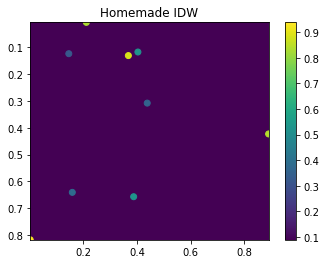

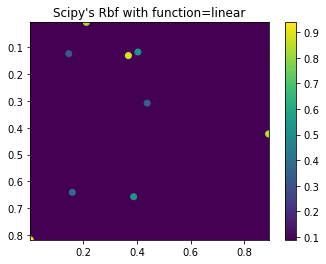

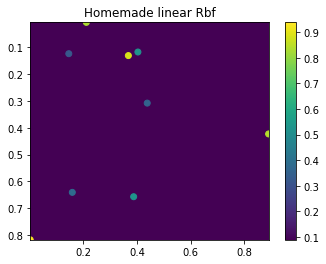

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

def main():
    # Setup: Generate data...
    n = 10
    nx, ny = 1, 1
    x, y, z = map(np.random.random, [n, n, n])
    print(x.shape,y.shape,z.shape)
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    print(xi.shape,yi.shape)
    xi, yi = np.meshgrid(xi, yi)
    xi, yi = xi.flatten(), yi.flatten()

    # Calculate IDW
    grid1 = simple_idw(x,y,z,xi,yi)
    print(grid1)
    grid1 = grid1.reshape((ny, nx))

    # Calculate scipy's RBF
    grid2 = scipy_idw(x,y,z,xi,yi)
    grid2 = grid2.reshape((ny, nx))

    grid3 = linear_rbf(x,y,z,xi,yi)
    print (grid3.shape)
    grid3 = grid3.reshape((ny, nx))


    # Comparisons...
    plot(x,y,z,grid1)
    plt.title('Homemade IDW')

    plot(x,y,z,grid2)
    plt.title("Scipy's Rbf with function=linear")

    plot(x,y,z,grid3)
    plt.title('Homemade linear Rbf')

    plt.show()

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

def linear_rbf(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # Mutual pariwise distances between observations
    internal_dist = distance_matrix(x,y, x,y)

    # Now solve for the weights such that mistfit at the observations is minimized
    weights = np.linalg.solve(internal_dist, z)

    # Multiply the weights for each interpolated point by the distances
    zi =  np.dot(dist.T, weights)
    return zi


def scipy_idw(x, y, z, xi, yi):
    interp = Rbf(x, y, z, function='linear')
    return interp(xi, yi)

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)


def plot(x,y,z,grid):
    plt.figure()
    plt.imshow(grid, extent=(x.min(), x.max(), y.max(), y.min()))
#     plt.hold(True)
    plt.scatter(x,y,c=z)
    plt.colorbar()

if __name__ == '__main__':
    main()

In [59]:
token = "pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A" # your mapbox token
tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

Map = folium.Map(
    location=[69.386080,-134.857734], zoom_start=9, tiles=tileurl, attr='Mapbox')

point=folium.CircleMarker(
        location=[69.386080,-134.857734],
        radius=10,
        popup='Fish Island',
        fill_opacity = 1,
        fill=True,
        color='black',
        line_weight=.35,
        fill_color='green'
).add_to(Map)

for lat,lon in zip(lats.flatten(),lons.flatten()):
    point=folium.CircleMarker(
            location=[lat,lon],
            radius=10,
            popup=str(lat)+' '+str(lon),
            fill_opacity = 1,
            fill=True,
            color='blue',
            line_weight=.35,
            fill_color='blue'
    ).add_to(Map)
Map